# 概述

数据预处理

Data pre-processing

# 重复值处理

数据集-摩托车的销售情况数据
- Condition:摩托车新旧情况（new:新的,used:使用过的）
- Condition_Desc:对当前状况的描述
- Price:价格
- Location:发货地址
- Model_Year:购买年份
- Mileage:里程
- Exterior_Color:车的颜色
- Make:制造商（牌子）
- Warranty:保修
- Model:类型
- Sub_Model:车辆类型
- Type:种类
- Vehicle_Title:车辆主题
- OBO:车辆仪表盘
- Watch_Count:表数
- N_Reviews:评测次数
- Seller_Status:卖家身份
- Auction:拍卖（Ture或者False）
- Buy_Now:现买
- Bid_Count:出价计数

In [ ]:
import pandas as pd
df = pd.read_csv('data/MotorcycleData.csv',encoding = 'gbk',na_values='Na')
print(df.head(5))
# 自定义一个函数对价格和里程数数据进行处理
def f(x):
    if '$' in str(x):
        x = str(x).strip('$')
        x = str(x).replace(',','')
    else:
        x = str(x).replace(',','')
    return float(x)
df['Price'] =  df['Price'].apply(f)
df['Mileage'] = df['Mileage'].apply(f)
print('数据集是否存在重复观测: \n', any(df.duplicated()))
print(df[df.duplicated()]) # 查看那些数据重复
print("重复数: \n", np.sum(df.duplicated()))
df.drop_duplicates()    # 删除所有变量都重复的行
df.drop_duplicates(subset= ['Condition','Condition_Desc','Price','Location'],inplace=True)  # 按照两个变量去重
df.info()

In [ ]:
df = pd.read_csv('data/cart.csv', parse_dates=['date'])
df.duplicated()
df.duplicated(['date', 'name'])

## 清洗-重复数据-多列重复-pandas

In [ ]:
#!/usr/bin/env python3
# -*- encoding: utf-8 -*-

# 完全重复：删除指定列数据完全相同的记录，不可重复列由业务分析得出

# 导入相应数据库客户端
import mysql.connector as mdb

# *引入并配置 pandas 显示参数
import pandas as pd
pd.set_option('display.width', 150)
pd.set_option('display.max_columns', 10)
pd.options.display.float_format = '{:,.2f}'.format

# 设置目标 table 查询语句以提取数据
targettable = "name"

# 使用 mysql api 和 read_sql() 从 mysql 获取和加载数据
host = "pdccmysql"
user = "pdccuser"
password = "pdccpass"
database = "pdccschema"
connmysql = mdb.connect(host=host,database=database,user=user,password=password)
df = pd.read_sql_table(table_name=targettable,con=connmysql)    # 生成 DataFrame
connmysql.close()

# 将 DataFrame 中的一个或多个列设置为索引（一般不列入重复记录计算）
df.set_index(["column1_name",'column2_name'], inplace=True)

# 可选仅考虑某些列来识别重复数据，默认情况下使用所有列
uniqueSet=['column3','column4','column5','...']

# 统计重复数据
df.duplicated(subset=uniqueSet).sum()

# 删除重复数据
df.drop_duplicates(subset=uniqueSet,inplace=True,ignore_index=True)

# 写入数据库，method = 'multi' 需要数据库支持 
df.to_sql(name=targettable,con=connmysql,if_exists='replace',chunksize=1000)
connmysql.close()

## 清洗-重复数据-字符串相似度-编辑距离-fuzzywuzzy

In [ ]:
#!/usr/bin/env python3
# -*- encoding: utf-8 -*-

# 字符串相似度-编辑距离：指定列数据(String)，识别相似度高的重复项并删除

# 导入相应数据库客户端
import mysql.connector as mdb
import pandas as pd
from fuzzywuzzy import process

# 设置目标 table 查询语句以提取数据
targettable = "name"

# 使用 mysql api 和 read_sql() 从 mysql 获取和加载数据
host = "pdccmysql"
user = "pdccuser"
password = "pdccpass"
database = "pdccschema"
connmysql = mdb.connect(host=host,database=database,user=user,password=password)
df = pd.read_sql_table(table_name=targettable,con=connmysql)    # 生成 DataFrame
connmysql.close()

# 将 DataFrame 中的一个或多个列设置为索引
df.set_index(["column1_name"], inplace=True)

# 查找重复字符串函数
def find_duplicates(dataframe, column_name, threshold=90):
    """
    检测DataFrame中指定列的重复项。
    :param dataframe: 要处理的DataFrame。
    :param column_name: 要检测重复项的列名。
    :param threshold: 相似度阈值，默认为90。
    :return: 包含重复数据的索引列表。
    """
    duplicates = set()
    for i in range(len(dataframe)):
        for j in range(i + 1, len(dataframe)):
            # 计算当前行与所有行的相似度，并获取最高分
            match = process.extractOne(dataframe[column_name].iloc[i], dataframe[column_name])
            # 如果匹配分数大于阈值，则认为是重复数据
            if match[1] > threshold:
                duplicates.add(j)
    return list(duplicates)

# 调用函数并打印结果
duplicates_indices = find_duplicates(df, 'column_str')
df_cleaned = df.drop(duplicates_indices).reset_index(drop=True)

# 写入数据库，method = 'multi' 需要数据库支持 
df.to_sql(name=targettable,con=connmysql,if_exists='replace',chunksize=1000)
connmysql.close()

## 清洗-重复数据-字符串相似度-余弦相似度-sklearn

'pip install scikit-learn -i https://pypi.tuna.tsinghua.edu.cn/simple'

In [ ]:
#!/usr/bin/env python3
# -*- encoding: utf-8 -*-

# 余弦相似度-字符串：指定列数据(String)，识别相似度高的重复项并删除

# 导入相应数据库客户端
import mysql.connector as mdb
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer 
from sklearn.metrics.pairwise import cosine_similarity

# 设置目标 table 查询语句以提取数据
targettable = "name"

# 使用 mysql api 和 read_sql() 从 mysql 获取和加载数据
host = "pdccmysql"
user = "pdccuser"
password = "pdccpass"
database = "pdccschema"
connmysql = mdb.connect(host=host,database=database,user=user,password=password)
df = pd.read_sql_table(table_name=targettable,con=connmysql)    # 生成 DataFrame
connmysql.close()

# 将 DataFrame 中的一个或多个列设置为索引
df.set_index(["column1_name"], inplace=True)
# 将 DataFrame 中的字符串列转换为 np.ndarray 对象
array = pd.Series(df['column_string_name']).to_numpy()
# 数据矢量化
vectorizer = TfidfVectorizer()
# 计算统计量并转换数据
vectors = vectorizer.fit_transform(array.astype('U'))
# 计算余弦相似度
similarities = cosine_similarity(vectors)
# 查找重复
duplicates=set()
for i in range (len(similarities)):
    for j in range(i+1, len(similarities)):
        if similarities[i][j] > 0.95:
            duplicates.add (j)
# 删除重复内容
df.drop(index=duplicates,inplace=True)

# 写入数据库，method = 'multi' 需要数据库支持 
df.to_sql(name=targettable,con=connmysql,if_exists='replace',chunksize=1000)
connmysql.close()

## TODO 清洗-重复数据-余弦相似度-sklearn

In [ ]:
import numpy as np
import pandas as pd

def cosine_similarity(df):
    """
    计算数据帧中每行之间的余弦相似度
    """
    # 计算每一行的L2范数
    norms = df.apply(np.linalg.norm, axis=1)

    # 计算余弦相似度
    cosine_sim = df.dot(df.T).divide(np.outer(norms, norms))

    # 将对角线设置为NaN，因为每行与自己的余弦相似度为1
    np.fill_diagonal(cosine_sim.values, np.nan)

    # 将余弦相似度存储在数据框中
    sim_df = pd.DataFrame(cosine_sim.values, index=df.index, columns=df.index)

    return sim_df

# 示例电影评分数据集
ratings_df = pd.DataFrame({
    'user0': ["c some sample data", 1, 2, 0, 2],
    'user1': [1, "b some sample data", 4, 1, 0],
    'user2': [2, 4, "c some sample data", 1, 1],
    'user3': [1, 2, 1, 3, 4],
    'user4': [4, "a some sample data", 3, 2, 0]
}, index=['movie0', 'movie1', 'movie2', 'movie3', 'movie4'])

# 计算每个用户之间的余弦相似度
similarity_df = cosine_similarity(ratings_df)
print(similarity_df.head(10))
print(ratings_df.head(10))

# 缺失值处理

In [ ]:
df.apply(lambda x: sum(x.isnull())/len(x),axis= 0)  #缺失比例
# 删除法
df.dropna() # 直接删除法
df.dropna(how='any',axis = 1 )  # 只要有缺失，就删除这一列
df.dropna(how='any',axis = 0)   # 只要有缺失，就删除这一行，等价于df.dropna()
df.dropna(axis=0,how='any',subset=['Condition','Price','Mileage'])  # 只要有缺失，就删除这一行，基于三个变量
# 使用替换法进行缺失值的填补
df.head(10)
df.Mileage.fillna(df.Mileage.mean())    # 年龄用均值填补
df.Mileage.fillna(df.Mileage.median())  # 中位数填补
df[df['Exterior_Color'].isnull()]
df.Exterior_Color.fillna(df.Exterior_Color.mode()[0])   # 众数填补
df.fillna(20)   # 所有缺失用20填补
# 婚姻状况使用众数，年龄使用均值，农户家庭人数使用中位数
df.fillna(value = {'Exterior_Color':df.Exterior_Color.mode()[0],'Mileage':df.Mileage.mean()})
df['Exterior_Color'].ffill() # 前向填补
df['Exterior_Color'].bfill() # 后向填补

In [ ]:
df = pd.read_csv('data/cart.csv', parse_dates=['date'])
df['amount'].astype('Int32')
df.isnull()
df.isnull().any(axis=1)

# 异常值处理

In [ ]:
# 按需进行数值转换 
df.head(5)
df['Price'].str[0:4]    # 字符串切片
# 将价格转换为float:需要先进行字符串处理
df['Price']=df['Price'].str.strip('$')
df['Price']=df['Price'].str.replace(',','')
df['Price']=df['Price'].astype(float)
df.Model.head(5)
df['Location'].str.split(',') # 使用字符串分割,用于对文本的处理
df['Mileage'].str.len() #计算字符串长度

In [ ]:
# 剔除户主姓名,户主身份证号和年龄有缺失的样本
df.dropna(axis = 0,how='any',subset=['Price'],inplace = True)   # 只要有缺失，就删除这一行,基于变量
# 异常值检测之标准差法-均值的2倍标准差范围
xbar = df.Price.mean() 
xstd = df.Price.std()
print('标准差法异常值上限检测：\n',any(df.Price> xbar + 2.5 * xstd))
print('标准差法异常值下限检测：\n',any(df.Price< xbar - 2.5 * xstd))
# 异常值检测之箱线图法-上下4分位数差方法
Q1 = df.Price.quantile(q = 0.25)
Q3 = df.Price.quantile(q = 0.75)
IQR = Q3 - Q1
print('箱线图法异常值上限检测：\n',any(df.Price > Q3 + 1.5 * IQR))
print('箱线图法异常值下限检测：\n',any(df.Price < Q1 - 1.5 * IQR))
df.Price.describe() # 对年龄进行描述性统计

# 用99分位数和1分位数替换

# 计算P1和P99
P1 =df.Price.quantile(0.01); P99 = df.Price.quantile(0.99)
# 先创建一个新变量，进行赋值，然后将满足条件的数据进行替换
df['Price_new'] = df['Price']
df.loc[df['Price'] > P99,'Price_new']  = P99
df.loc[df['Price'] < P1,'Price_new']  = P1
df[['Price','Price_new']].describe()

## z_score

                      time name         value
35 2021-07-13 14:37:08.649  mem  2.275387e+08
67 2021-07-13 14:37:23.961  mem  2.275173e+08
12 2021-07-13 14:36:58.122  mem  2.275156e+08
62 2021-07-13 14:37:22.047  cpu  3.095000e+01
42 2021-07-13 14:37:12.477  mem  2.275487e+08
53 2021-07-13 14:37:17.262  mem  2.275512e+08
79 2021-07-13 14:37:29.703  mem  2.275184e+08
14 2021-07-13 14:36:59.079  CPU  3.040000e+01
56 2021-07-13 14:37:19.176  cpu  3.060000e+01
78 2021-07-13 14:37:29.703  cpu  3.700000e+01
     value                                                                  \
     count          mean           std     min           25%           50%   
name                                                                         
CPU    1.0  3.040000e+01           NaN   30.40  3.040000e+01  3.040000e+01   
cpu   49.0  3.645633e+01  3.977927e+01  -32.14  2.956000e+01  3.157000e+01   
mem   50.0  2.229711e+08  3.217637e+07  295.00  2.275070e+08  2.275188e+08   

                         

,time,name,value
6,2021-07-13 14:36:55.251,mem,295.0


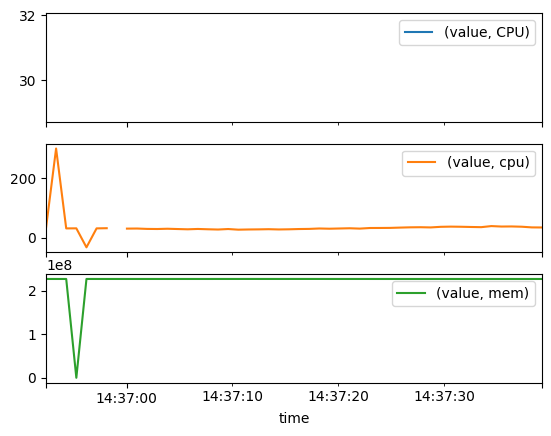

In [2]:
import pandas as pd
# 载入数据
df = pd.read_csv('data/metrics.csv', parse_dates=['time'])
print(df.sample(10))
# 快速分组统计
print(df.groupby('name').describe())
# 按列分组计数
print(df['name'].value_counts())
# 返回按给定 "index / column" 值组织的重塑 DataFrame 生成 "透视(pivot)" 表
pd.pivot(df, index='time', columns='name').plot(subplots=True)
df.query('name == "cpu" & (value < 0 | value > 100)')
mem = df[df['name'] == 'mem']['value']
# 计算 z 分数（也称为标准分数，一个数据点离平均值有多远）
z_score = (mem - mem.mean())/mem.std()
print(z_score.head(10))
# 设定阀值
bad_mem = mem[z_score.abs() > 2]
# 定位输出超过阀值的数据
df.loc[bad_mem.index]

# 数据离散化

In [ ]:
# cut
df.head(5)
df['Price_bin']=pd.cut(df['Price_new'],5,labels=range(5))
# 自定义分段标准和标签
df['Price_new'].describe()
w = [100,1000,5000,10000,20000,50000]
df['Price_bin'] = pd.cut(df['Price_new'], bins =w,labels=['低','便宜','划算','中等','高'],right=False)
df['Price_bin'].value_counts()
# qcut
k = 5
w = [1.0*i/k for i in range(k+1)] 
w
df['Price_bin'] = pd.qcut(df['Price_new'],w,labels=range(k))
# 或者先计算分位数的值
k = 5
w1 = df['Price_new'].quantile([1.0*i/k for i in range(k+1)])    # 先计算分位数,在进行分段
w1[0] = w1[0]* 0.95 # 最小值缩小一点
w[-1] = w1[1]* 1.05 # 将最大值增大一点, 目的是为了确保数据在这个范围内
w1
df['Price_bin'] = pd.cut(df['Price_new'],w1,labels=range(k))